![](https://raw.githubusercontent.com/fdannemanndugick/roses2021/main/header.png)

<hr style="border:2px solid gray"> </hr>

# <center>FakeQuakes Synthetic Data Generation Lab</center>
## <center>Instructor: Tara Nye</center>

<hr style="border:2px solid gray"> </hr>

***
## Overview

The purpose of this exercise is to get familiar with the parameters and functions used to generate synthetic data using the forward modeling code FakeQuakes from the [MudPy](https://github.com/dmelgarm/MudPy) Github repository. FakeQuakes was created by __Dr. Diego Melgar__ (professor at the Unviersity of Oregon), and most of the components are outlined in the paper [__Kinematic rupture scenarios and synthetic displacement data: An example application to the Cascadia subduction zone__ (Melgar et al., 2016)](http://doi.wiley.com/10.1002/2016JB013314).  

This set of codes generates synthetic rupture models and can generate low frequency displacement waveforms and broadband acceleration waveforms.

For this lab, we will be using data from the Mentawai, Indonesia region.

For more information on how to use FakeQuakes, you can refer to this [wiki page](https://github.com/taranye96/tsuquakes/wiki/FakeQuakes-Script) on my github account.  This wiki page walks you through how to set up the parameter file (__.fq.py__) listed in the [tsuquakes](https://github.com/taranye96/tsuquakes) respository and how to run the different steps in FakeQuakes.  If you have any other questions, feel free to contact me or Diego Melgar.

Tara Nye: tnye@uoregon.edu
<br>Diego Melgar: dmelgarm@uoregon.edu

***
## Project Setup

If you haven't already, you will need to install MudPy following the instructions below:

#### 1. Clone MudPy repository 
**`$ git clone https://github.com/dmelgarm/MudPy.git`**
#### 2. Build the fk Green's function code
#### - Inside *MudPy/src/fk/* run:
**`$ make clean`**

**`$ make all`**
#### 3. Set Paths (.bash_profile or .bashrc script)
#### - Add the Mudpy src/fk folder to your PATH variable 
#### i.e. in my .bash_profile script I have:
**`export PATH=/Users/tnye/code/MudPy/src/fk:$PATH`**
#### - Add the Mudpy src/python folder to your PYTHONPATH 
#### i.e. in my .bash_profile script I have:
**`export PYTHONPATH=/Users/tnye/code/MudPy/src/python:$PYTHONPATH`**
#### - Define the MUD environment variable
#### i.e. in my .bash_profile script I have:
**`export MUD=/Users/tnye/code/MudPy`**

**Note:** You may need to reload your .bash_profile (or .bashrc) script after making changes to it by typing
**`$ source .bash_profile`**
into the terminal.

***
Before generating synthetic data, you will need to set up a project folder.  FakeQuakes has a function to initialize a set of directories, given a **home** and **project_name** variable.  **/path/to/home/project_name/** is the path to the subdirectories that FakeQuakes will create.  These subdirectories will store the rupture files, Green's functions, waveforms, etc...

You will need to create a new project folder for each new set of parameters (ex. new project for each exercise in the lab), but the **home** variable can stay the same. This is demonstrated under each exercise. 

In the **files** folder, I have included the three files you will need:
- **mentawai.mod** (velocity model for Mentawai region)
- **mentawai.fault** (Mentawai fault model)
- **sm.gflist** (list of strong motion stations used to generate waveforms)

***

In [1]:
# Standard Library Imports
import os
import numpy as np
from obspy.core import UTCDateTime
from obspy import read

# MudPy Imports
!pip install numba  # Numba is already installed with Anaconda, but it is not in the roses_2021 conda environment 
from mudpy import fakequakes,runslip,forward,view

## Parameter List
This is the full list of parameters used to run the different functions, but most of them you won't need to change. You need to run this cell though to define the parameters. There are descriptions next to each parameter, and I've included the important parameters you will need to define under each exercise.  

In [2]:
# Runtime parameters 
ncpus=2                                        # How many CPUS you want to use for parallelization (needs to be at least 2)
Nrealizations=2                                # Number of fake ruptures to generate per magnitude bin
hot_start=0

# File parameters
model_name='mentawai.mod'                      # Velocity model file name
fault_name='mentawai.fault'                    # Fault model name
mean_slip_name=None                            # Set to path of .rupt file if patterning synthetic runs after a mean rupture model
run_name='mentawai'                            # Base name of each synthetic run (i.e. mentawai.000000, mentawai.000001, etc...)
rupture_list='ruptures.list'                   # Name of list of ruptures that are used to generate waveforms.  'ruptures.list' uses the full list of ruptures FakeQuakes creates. If you create file with a sublist of ruptures, use that file name.
distances_name='mentawai'                      # Name of matrix with estimated distances between subfaults i and j for every subfault pair
load_distances=0                               # This should be zero the first time you run FakeQuakes with your fault model.

# Source parameters
UTM_zone='47M'                                 # UTM_zone for rupture region 
time_epi=UTCDateTime('2010-10-25T14:42:12Z')   # Origin time of event (can set to any time, as long as it's not in the future)
target_Mw=np.array([8.5])                      # Desired magnitude(s), can either be one value or an array
hypocenter=None                                # Coordinates of subfault closest to desired hypocenter, or set to None for random
force_hypocenter=False                         # Set to True if hypocenter specified
rake=90                                        # Average rake for subfaults
scaling_law='T'                                # Type of rupture: T for thrust, S for strike-slip, N for normal
force_magnitude=False                          # Set to True if you want the rupture magnitude to equal the exact target magnitude
force_area=False                               # Set to True if you want the ruptures to fill the whole fault model

# Correlation function parameters
hurst=0.4                                      # Hurst exponent form Melgar and Hayes 2019
Ldip='auto'                                    # Correlation length scaling: 'auto' uses Melgar and Hayes 2019, 'MB2002' uses Mai and Beroza 2002
Lstrike='auto'                                 # Same as above
slip_standard_deviation=0.9                    # Standard deviation for slip statistics: Keep this at 0.9
lognormal=True                                 # Keep this as True to solve the problem of some negative slip subfaults that are produced

# Rupture propagation parameters
rise_time_depths=[10,15]                       # Transition depths for rise time scaling (if slip shallower than first index, rise times are twice as long as calculated)
max_slip=40                                    # Maximum sip (m) allowed in the model
max_slip_rule=False                            # If true, uses a magntidude-depence for max slip
shear_wave_fraction=0.8                        # 0.8 is a standard value (Mai and Beroza 2002)
source_time_function='dreger'                  # options are 'triangle' or 'cosine' or 'dreger'
stf_falloff_rate=4                             # Only affects Dreger STF, 4-8 are reasonable values
num_modes=72                                   # Number of modes in K-L expansion
slab_name=None                                 # Slab 2.0 Ascii file for 3D geometry, set to None for simple 2D geometry
mesh_name=None                                 # GMSH output file for 3D geometry, set to None for simple 2D geometry

# Green's Functions parameters
GF_list='sm.gflist'                            # Stations file name
G_name='sm'                                    # Basename you want for the Green's functions matrices
make_GFs=1                                     # This should be 1 to run Green's functions
make_synthetics=1                              # This should be 1 to make the synthetics
G_from_file=0                                  # This should be zero the first time you run FakeQuakes with your fault model and stations.

# fk parameters
# used to solve wave equation in frequency domain 
dk=0.1 ; pmin=0 ; pmax=1 ; kmax=20             # Should be set to 0.1, 0, 1, 20
custom_stf=None                                # Assumes specified source time function above if set to None

# Low frequency waveform parameters
dt=0.5                                         # Sampling interval of LF data 
NFFT=512                                       # Number of samples in LF waveforms (should be in powers of 2)
# dt*NFFT = length of low-frequency dispalcement record
# want this value to be close to duration (length of high-frequency record)

# High frequency waveform parameters
stress_parameter=50                            # Stress drop measured in bars (standard value is 50)
moho_depth_in_km=30.0                          # Average depth to Moho in this region 
Pwave=True                                     # Calculates P-waves as well as S-waves if set to True, else just S-Waves
kappa=None                                     # Station kappa values: Options are GF_list for station-specific kappa, a singular value for all stations, or the default 0.04s for every station if set to None
hf_dt=0.01                                     # Sampling interval of HF data
duration=250                                   # Duration (in seconds) of HF record

high_stress_depth=30                           # Doesn't do anything, but still shows up as a parameter. Set to whatever you want. 

# Match filter parameters
zero_phase=True                                # If True, filters waveforms twice to remove phase shift, else filters once
order=4                                        # Number of poles for filters
fcorner=0.998                                  # Corner frequency at which to filter waveforms (needs to be between 0 and the Nyquist frequency)

<hr style="border:1px solid gray"> </hr>

## 1. Generate two rupture models for a thrust earthquake with a target magnitude of 8.5.  Set the hypocenter to be a random subfault.

#### Define variables for project folder
Note: I set **home** as your current working directory, but you can change it to be located in a different location.

In [3]:
home = os.getcwd() + '/' # This sets the current working directory as the home path
project_name='lab1' # Name of project folder that will be set up in home directory

#### Initalize project folder

In [4]:
fakequakes.init(home,project_name)

#### Copy over the files into their respective directories
- __.mod__ should be placed in __*/home/project_name/structure/*__ 
- __.fault__ should be placed in __*/home/project_name/data/model_info/*__
- __.gflist__ file should be placed in __*/home/project_folder/data/station_info/*__

In [5]:
!cp ./files/mentawai.mod $home/$project_name/structure
!cp ./files/mentawai.fault $home/$project_name/data/model_info
!cp ./files/sm.gflist $home/$project_name/data/station_info

#### Change the needed parameters

In [6]:
Nrealizations = 2                 # Integer number of synthetic rupture models
target_Mw = np.array([8.5])         # Has to be an array, even if you only want one target Mw
hypocenter  =  None                  # None or [lon, lat, depth]
force_hypocenter =  False             # True or False
scaling_law = 'T'                   # 'T' for thrust, 'S' for strike-slip, or 'N' for normal
force_magnitude =  False              # True or False

#### Generate rupture models (~45 seconds)

In [7]:
fakequakes.generate_ruptures(home,project_name,run_name,fault_name,slab_name,mesh_name,load_distances,
        distances_name,UTM_zone,target_Mw,model_name,hurst,Ldip,Lstrike,num_modes,Nrealizations,rake,
        rise_time_depths,time_epi,max_slip,source_time_function,lognormal,slip_standard_deviation,scaling_law,
        ncpus,mean_slip_name=mean_slip_name,force_magnitude=force_magnitude,force_area=force_area,
        hypocenter=hypocenter,force_hypocenter=force_hypocenter,shear_wave_fraction=shear_wave_fraction,
        max_slip_rule=max_slip_rule)   

Building obspy.taup model for '/Users/tnye/FakeQuakes_tutorial/lab1/structure/mentawai.nd' ...
MPI: Starting 2 FakeQuakes Rupture Generations on  2 CPUs
None


#### View rupture models

/Users/tnye/ROSES/MudPy/src/python/mudpy/view.py:2879: RuntimeWarning: invalid value encountered in true_divide
  ds=ds/((ds**2+ss**2)**0.5)
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


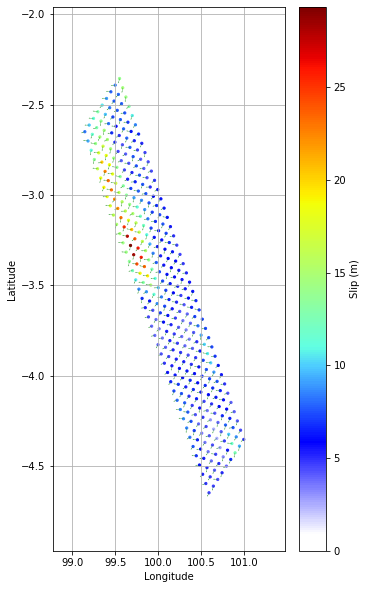

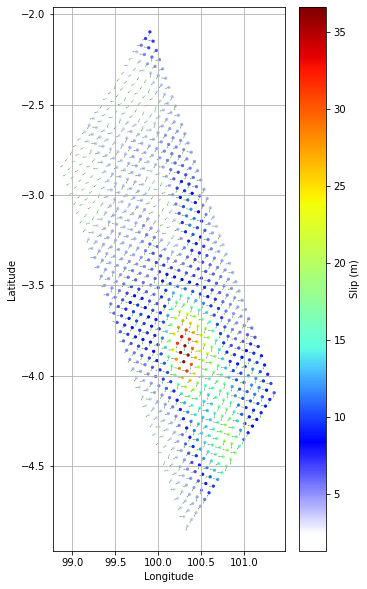

In [8]:
%matplotlib inline
view.quick_model(f'{home}/{project_name}/output/ruptures/mentawai.000000.rupt')
view.quick_model(f'{home}/{project_name}/output/ruptures/mentawai.000001.rupt')

In [10]:
# View logfile for first rupture
logpath=os.getcwd() +'/' + project_name + '/output/ruptures/mentawai.000001.log'
var=!cat $logpath
var

['Scenario calculated at 2021-06-22 17:21:19 GMT',
 'Project name: lab1',
 'Run name: mentawai',
 'Run number: 000001',
 'Velocity model: mentawai.mod',
 'No. of KL modes: 72',
 'Hurst exponent: 0.4',
 'Corr. length used Lstrike: 96.61 km',
 'Corr. length used Ldip: 54.40 km',
 'Slip std. dev.: 0.900 km',
 'Maximum length Lmax: 273.06 km',
 'Maximum width Wmax: 140.00 km',
 'Effective length Leff: 232.10 km',
 'Effective width Weff: 119.00 km',
 'Target magnitude: Mw 8.5000',
 'Actual magnitude: Mw 8.7927',
 'Hypocenter (lon,lat,z[km]): (100.399307,-3.848457,21.00)',
 'Hypocenter time: 2010-10-25T14:42:12.000000Z',
 'Centroid (lon,lat,z[km]): (100.354169,-3.692972,21.85)',
 'Source time function type: dreger']

#### Compute Green's functions (~9 minutes)

In [11]:
# I changed ncpus to 4 to speed up computation time, but you can decrease it if you don't have 4 CPUs on your machine
ncpus=4
runslip.inversionGFs(home,project_name,GF_list,None,fault_name,model_name,
        dt,None,NFFT,None,make_GFs,make_synthetics,dk,pmin,
        pmax,kmax,0,time_epi,hot_start,ncpus,custom_stf,impulse=True) 

Displacememnt GFs requested...
MPI: Starting GFs computation on 4 CPUs

mpiexec -n 4 python /Users/tnye/ROSES/MudPy/src/python/mudpy/parallel.py run_parallel_green /Users/tnye/FakeQuakes_tutorial/ lab1 /Users/tnye/FakeQuakes_tutorial/lab1/data/station_info/temp.sta mentawai.mod 0.5 512 0 0.1 0 1 20 False False
Displacement synthetics requested
MPI: Starting synthetics computation on 4 CPUs

mpiexec -n 4 python /Users/tnye/ROSES/MudPy/src/python/mudpy/parallel.py run_parallel_synthetics /Users/tnye/FakeQuakes_tutorial/ lab1 /Users/tnye/FakeQuakes_tutorial/lab1/data/station_info/temp.sta mentawai.mod 1 0 False 2010-10-25T14:42:12.000000Z 0 None True False False 45000000000.0


#### Make low-frequency waveforms (~20 seconds)

In [12]:
forward.waveforms_fakequakes(home,project_name,fault_name,rupture_list,GF_list,
        model_name,run_name,dt,NFFT,G_from_file,G_name,source_time_function,
        stf_falloff_rate)

Solving for kinematic problem(s)
... loading all synthetics into memory
Reading green functions for station #1 of 2
Reading green functions for station #2 of 2
Writting synthetics to miniSEED, hang on this might take a minute or two.
... ... done
... solving for source 0 of 2
mentawai.000000.rupt
... working on station 0 of 2
... working on station 1 of 2
... solving for source 1 of 2
mentawai.000001.rupt
... working on station 0 of 2
... working on station 1 of 2


#### Plot the low-frequency dispalcement waveforms for the PPSI and MNSI stations
**Note:** You can use Obspy to read in the sac files, and you can plot using matplotlib or Obspy's built in plotting function.  The low-frequency displacement waveforms are located in **/home/project_name/output/waveforms**, and they have an **LY*** channel code. 

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


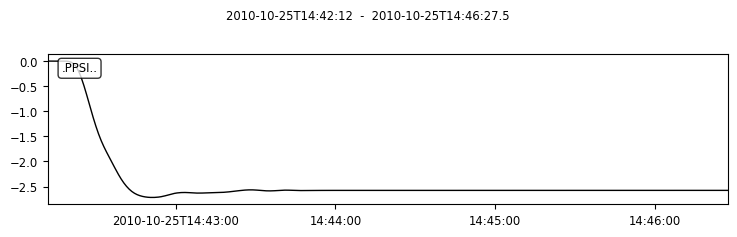

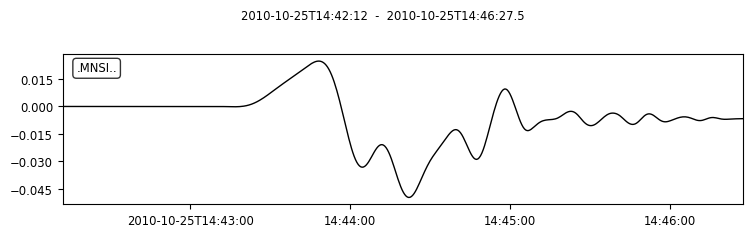

In [13]:
st1 = read(f'{home}/{project_name}/output/waveforms/mentawai.000000/PPSI.LYE.sac')
tr1 = st1[0]
st2 = read(f'{home}/{project_name}/output/waveforms/mentawai.000000/MNSI.LYE.sac')
tr2 = st2[0]

tr1.plot()
tr2.plot()

Station PPSI is located closer to the fault than MNSI, so it has a permanent static offset (permanent deformation).  MNSI returns to a displacement offset near 0 because it is further away from the fault and experiences little permanent deformation.

**Note:** If you only want to make low-frequency displacement waveforms (i.e. for GNSS stations), you would stop here.  If you want to make broadband waveforms, you would need to continue with the next few steps.

#### Make high-frequency waveforms (~4 minutes)

In [14]:
forward.hf_waveforms(home,project_name,fault_name,rupture_list,GF_list,
                model_name,run_name,dt,NFFT,G_from_file,G_name,rise_time_depths,
                moho_depth_in_km,ncpus,source_time_function=source_time_function,
                duration=duration,stf_falloff_rate=stf_falloff_rate,hf_dt=hf_dt,
                Pwave=Pwave,hot_start=hot_start,stress_parameter=stress_parameter,
                high_stress_depth=high_stress_depth)

... solving HF waveforms for source 0 of 2
MPI: Starting Stochastic High Frequency Simulation on  4 CPUs
MPI: Starting Stochastic High Frequency Simulation on  4 CPUs
MPI: Starting Stochastic High Frequency Simulation on  4 CPUs
MPI: Starting Stochastic High Frequency Simulation on  4 CPUs
MPI: Starting Stochastic High Frequency Simulation on  4 CPUs
MPI: Starting Stochastic High Frequency Simulation on  4 CPUs
... solving HF waveforms for source 1 of 2
MPI: Starting Stochastic High Frequency Simulation on  4 CPUs
MPI: Starting Stochastic High Frequency Simulation on  4 CPUs
MPI: Starting Stochastic High Frequency Simulation on  4 CPUs
MPI: Starting Stochastic High Frequency Simulation on  4 CPUs
MPI: Starting Stochastic High Frequency Simulation on  4 CPUs
MPI: Starting Stochastic High Frequency Simulation on  4 CPUs


#### Plot the high-frequency acceleration waveforms for the PPSI and MNSI stations
**Note:** The high-frequency acceleration waveforms are located in **/home/project_name/output/waveforms**, and they have an **HN*** channel code. 

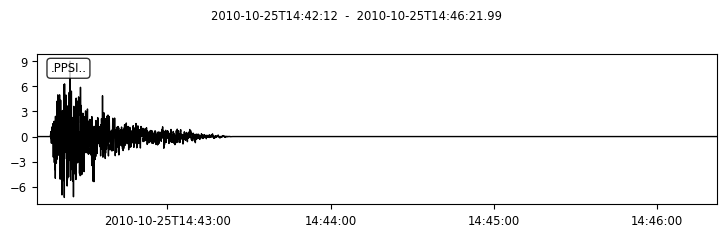

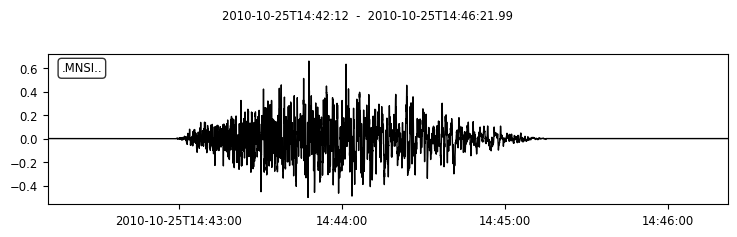

In [15]:
st1 = read(f'{home}/{project_name}/output/waveforms/mentawai.000000/PPSI.HNE.mpi.sac')
tr1 = st1[0]
st2 = read(f'{home}/{project_name}/output/waveforms/mentawai.000000/MNSI.HNE.mpi.sac')
tr2 = st2[0]

tr1.plot()
tr2.plot()

#### Combine LF and HF waveforms using a matched filter                              

In [16]:
forward.match_filter(home,project_name,fault_name,rupture_list,GF_list,zero_phase,order,fcorner)

Running matched filter for all stations for rupture mentawai.000000.rupt
Running matched filter for all stations for rupture mentawai.000001.rupt


#### Plot the broadband acceleration waveforms for the PPSI and MNSI stations
**Note:** The broadband acceleration waveforms are located in **/home/project_name/output/waveforms**, and they have a **bb.HN*** channel code. 

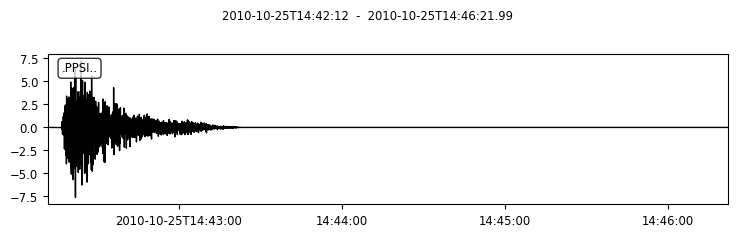

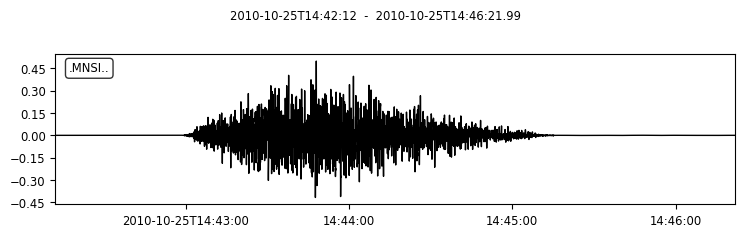

In [17]:
st1 = read(f'{home}/{project_name}/output/waveforms/mentawai.000000/PPSI.bb.HNE.sac')
tr1 = st1[0]
st2 = read(f'{home}/{project_name}/output/waveforms/mentawai.000000/MNSI.bb.HNE.sac')
tr2 = st2[0]

tr1.plot()
tr2.plot()

If you compare these broadband waveforms with the high-frequency ones, you can see more long-period energy contribution from the low-frequency waveforms.

<hr style="border:1px solid gray"> </hr>

## 2. Generate two rupture models for a M8 thrust earthquake.  Set the hypocenter to be the subfault with the coordinates 100.857727, -4.374691, 21.974.

#### Define variables for project folder
**Note:** You can keep **home** the same and just change **project_name**.

In [ ]:
home = os.getcwd() + '/' # This sets the current working directory as the home path
project_name='' 

#### Initialize project folder

In [ ]:
fakequakes.init(home,project_name)

#### Copy over the files into their respective directories

In [ ]:
!cp ./files/mentawai.mod $home/$project_name/structure
!cp ./files/mentawai.fault $home/$project_name/data/model_info
!cp ./files/sm.gflist $home/$project_name/data/station_info

**Note:** If you have already generated data for this fault file and set of stations, you can use the subfault distances and Green's functions matrices that were created previously, rather than make them from scratch every time.  This will speed up computation time for future runs. 
- set **G_from_file=1**
- set **load_distances=1**
- copy over .mseed files from **/GFs/matrices** from your previous project folder to your new one
- copy over files from **/data/distances** from your previous project folder to your new one

In [ ]:
# Project name from previous exercise
project_name_old = ''

In [ ]:
!cp -a $home/$project_name_old/GFs/matrices/. $home$project_name/GFs/matrices/
!cp -a $home/$project_name_old/data/distances/. $home$project_name/data/distances/

#### Change the needed parameters

In [ ]:
Nrealizations = 
target_Mw = np.array([])
hypocenter  = []
force_hypocenter = 
scaling_law = 
force_magnitude =              
force_area =

load_distances = 1
G_from_file = 1

#### Generate rupture models (~20 seconds)

In [ ]:
# Change ncpus to 2 so that we only create 2 rupture scenarios. If it is left at 4, it will try to create 4 scenarios.
ncpus=2

fakequakes.generate_ruptures(home,project_name,run_name,fault_name,slab_name,mesh_name,load_distances,
        distances_name,UTM_zone,target_Mw,model_name,hurst,Ldip,Lstrike,num_modes,Nrealizations,rake,
        rise_time_depths,time_epi,max_slip,source_time_function,lognormal,slip_standard_deviation,scaling_law,
        ncpus,mean_slip_name=mean_slip_name,force_magnitude=force_magnitude,force_area=force_area,
        hypocenter=hypocenter,force_hypocenter=force_hypocenter,shear_wave_fraction=shear_wave_fraction,
        max_slip_rule=max_slip_rule)   

#### View rupture models

In [ ]:
%matplotlib inline
#%matplotlib notebook
logpath=os.getcwd() + '/' + project_name + '/output/ruptures/mentawai.000000.log'
var=!cat $logpath
var
view.quick_model(f'{home}{project_name}/output/ruptures/mentawai.000000.rupt')
view.quick_model(f'{home}{project_name}/output/ruptures/mentawai.000001.rupt')

#### Compute Green's functions and make low-frequency displacement waveforms (~9 minutes)

In [ ]:
# Change ncpus to 4 to speed up computation time
ncpus=4

runslip.inversionGFs(home,project_name,GF_list,None,fault_name,model_name,
        dt,None,NFFT,None,make_GFs,make_synthetics,dk,pmin,
        pmax,kmax,0,time_epi,hot_start,ncpus,custom_stf,impulse=True) 

forward.waveforms_fakequakes(home,project_name,fault_name,rupture_list,GF_list,
        model_name,run_name,dt,NFFT,G_from_file,G_name,source_time_function,
        stf_falloff_rate)

#### Plot the low-frequency displacement waveforms for the PPSI and MNSI stations

#### Make high-frequency waveforms (~2 minutes)

In [ ]:
import timestart = time.time()
forward.hf_waveforms(home,project_name,fault_name,rupture_list,GF_list,
                model_name,run_name,dt,NFFT,G_from_file,G_name,rise_time_depths,
                moho_depth_in_km,ncpus,source_time_function=source_time_function,
                duration=duration,stf_falloff_rate=stf_falloff_rate,hf_dt=hf_dt,
                Pwave=Pwave,hot_start=hot_start,stress_parameter=stress_parameter,
                high_stress_depth=high_stress_depth)
end = time.time()
time_elaps = end - start
if time_elaps < 60:
    print(f'Duration: {round(time_elaps)} seconds')
else:
    print(f'Duration: {round(time_elaps/60)} minutes') 

#### Plot the high-frequency acceleration waveforms for the PPSI and MNSI stations

#### Combine LF and HF waveforms with matched filter      

In [ ]:
forward.match_filter(home,project_name,fault_name,rupture_list,GF_list,zero_phase,order,fcorner)

#### Plot the east component of the broadband acceleration waveforms for the PPSI and MNSI stations

<hr style="border:1px solid gray"> </hr>

## 3. Generate two rupture models each for a M7.5 and M8.5 thrust earthquake.  Set the hypocenter to be random.

#### Define variables for project folder

In [ ]:
home = os.getcwd() + '/' # This sets the current working directory as the home path
project_name='' 

#### Initialize project folder

In [ ]:
fakequakes.init(home,project_name)

#### Copy over the files into their respective directories.

In [ ]:
!cp ./files/mentawai.mod $home/$project_name/structure
!cp ./files/mentawai.fault $home/$project_name/data/model_info
!cp ./files/sm.gflist $home/$project_name/data/station_info

#### Copy over distances and Green's functions files

In [ ]:
# Project name from previous exercise
project_name_old = ''

!cp -a $home/$project_name_old/GFs/matrices/. $home$project_name/GFs/matrices/
!cp -a $home/$project_name_old/data/distances/. $home$project_name/data/distances/

#### Change the needed parameters

In [ ]:
Nrealizations = 
target_Mw = np.array([])
hypocenter  = 
force_hypocenter = 
scaling_law = 
force_magnitude =                 

load_distances = 1
G_from_file = 1

#### Generate rupture models (~30 seconds)

In [ ]:
# Change ncpus to 2 so that we only create 2 rupture scenarios for each magnitude
ncpus=2

fakequakes.generate_ruptures(home,project_name,run_name,fault_name,slab_name,mesh_name,load_distances,
        distances_name,UTM_zone,target_Mw,model_name,hurst,Ldip,Lstrike,num_modes,Nrealizations,rake,
        rise_time_depths,time_epi,max_slip,source_time_function,lognormal,slip_standard_deviation,scaling_law,
        ncpus,mean_slip_name=mean_slip_name,force_magnitude=force_magnitude,force_area=force_area,
        hypocenter=hypocenter,force_hypocenter=force_hypocenter,shear_wave_fraction=shear_wave_fraction,
        max_slip_rule=max_slip_rule)   

#### View rupture models

In [ ]:
%matplotlib inline
#%matplotlib notebook
logpath=os.getcwd() + '/' + project_name + '/output/ruptures/mentawai.000000.log'
var=!cat $logpath
var

# First of the M7.5 ruptures
view.quick_model(f'{home}{project_name}/output/ruptures/mentawai.000000.rupt')
# First of the M8.5 ruptures
view.quick_model(f'{home}{project_name}/output/ruptures/mentawai.000002.rupt')

#### Compute Green's functions and make low-frequency dispalcement waveforms (~9 minutes)

In [ ]:
# Change ncpus to 4 to speed up computation time
ncpus=4

runslip.inversionGFs(home,project_name,GF_list,None,fault_name,model_name,
        dt,None,NFFT,None,make_GFs,make_synthetics,dk,pmin,
        pmax,kmax,0,time_epi,hot_start,ncpus,custom_stf,impulse=True) 

forward.waveforms_fakequakes(home,project_name,fault_name,rupture_list,GF_list,
        model_name,run_name,dt,NFFT,G_from_file,G_name,source_time_function,
        stf_falloff_rate)

#### Plot the low-frequency dispalcement waveforms for the PPSI and MNSI stations. 

#### Make high-frequency waveforms (~5 minutes)

In [ ]:
forward.hf_waveforms(home,project_name,fault_name,rupture_list,GF_list,
                model_name,run_name,dt,NFFT,G_from_file,G_name,rise_time_depths,
                moho_depth_in_km,ncpus,source_time_function=source_time_function,
                duration=duration,stf_falloff_rate=stf_falloff_rate,hf_dt=hf_dt,
                Pwave=Pwave,hot_start=hot_start,stress_parameter=stress_parameter,
                high_stress_depth=high_stress_depth)

#### Plot the high-frequency acceleration waveforms for the PPSI and MNSI stations

#### Combine LF and HF waveforms with matched filter      

In [ ]:
forward.match_filter(home,project_name,fault_name,rupture_list,GF_list,zero_phase,order,fcorner)

#### Plot the broadband acceleration waveforms for the PPSI and MNSI stations

<hr style="border:1px solid gray"> </hr>

# <center> Final Notes </center>
* All rupture files are stored in __/output/ruptures/__
* All waveforms are stored in __/output/waveforms/__
    * __.LY*.sac__ files are the low-frequency displacement files
    * __.HN*mpi.sac__ files are the high-frequency acceleration files
    * __.bb.HN*.sac__ files are the final broadband acceleration waveforms

### References
Blaser, L., F. Krüger, M. Ohrnberger, and F. Scherbaum (2010), Scaling relations of earthquake source parameter estimates with special focus on subduction environment, Bull. Seism. Soc. Am., 100, 2914–2926.

Graves, R., and A. Pitarka (2015), Refinements to the Graves and Pitarka (2010) broadband ground-motion simulation method, Seismol. Res. Lett., 86(1), 75–80.

Graves, R. W., & Pitarka, A. (2010), Broadband Ground-Motion Simulation Using a Hybrid Approach. Bulletin of the Seismological Society of America, 100(5A), 2095-2123. doi:10.1785/0120100057

Mai, P. M., and Beroza, G. C. (2002), A spatial random field model to characterize complexity in earthquake slip, J. Geophys. Res., 107(B11), 2308, doi:10.1029/2001JB000588

Melgar, D., Leveque, R. J., Dreger, D. S., & Allen, R. M. (2016), Kinematic rupture scenarios and synthetic displacement data: An example application to the Cascadia subduction zone. Journal of Geophysical Research: Solid Earth, 121(9), 6658-6674, doi:10.1002/2016jb013314

Yue, H., Lay, T., Rivera, L., Bai, Y., Yamazaki, Y., Cheung, K. F., … Muhari, A. (2014), Rupture process of the 2010 Mw 7.8 Mentawai tsunami earthquake from joint inversion of near-field hr-GPS and teleseismic body wave recordings constrained by tsunami observations. AGU: Journal of Geophysical Research, Solid Earth, 119, 5574–5593, doi:10.1002/2014JB011082

Zhu, L., & Rivera, L. A. (2002), A note on the dynamic and static displacements from a point source in multilayered media. Geophysical Journal International, 148(3), 619-627, doi:10.1046/j.1365-246x.2002.01610.x